In [1]:
#hide
from simple_interpolation.core import *

# `simple_interpolation`

> A Pandas implentation of the Brownian Bridge interpolation algorithm. Wiener processes are assumed to build `std()`.

Interpolation rocks, but doing it poorly can alter the original features of your data. **Brownian bridge preserves the volatibility of the original data**, if done well. Mixing that with a bit theory on the stock market (Wiener processes), we built a simple interpolation library.

Read **about the algorithm in the "Brownian bridge algo" section below**.

## Install

`pip install simple_interpolation`

## How to use

In [4]:
#hide
import pandas as pd

In [5]:
# hide
x = list(range(0,50))
y = [np.random.normal(loc = 10.0, scale = 1.5) for _ in x]

# Delete some points
points_to_remove = [3,4,5,17,18]
points_to_remove.extend(list(range(29,45)))
# points_to_remove.extend(list(range(55,60)))
# points_to_remove.extend(list(range(70,95)))
for removal in points_to_remove:
    i = x.index(removal)
    x.remove(removal)
    y.remove(y[i])
    
df = pd.DataFrame(list(zip(x, y)), 
               columns =['X', 'Y']) 

In [7]:
# Example input dataframe, containing gaps
#  (i. e. X column, values 3-5)
df

,X,Y
0,0,8.089846
1,1,11.793489
2,2,9.026726
3,6,8.996177
4,7,11.221730
5,8,8.398122
6,9,8.845667
7,10,11.454700
8,11,11.431745
9,12,7.050733


No datetime column: assuming first column 'X' as X-axis
std() built with Wiener method
Will interpolate if X-column interval is more than 1.7675
Processed 0.00% of gaps
Ended interpolation, starting plotting the results..


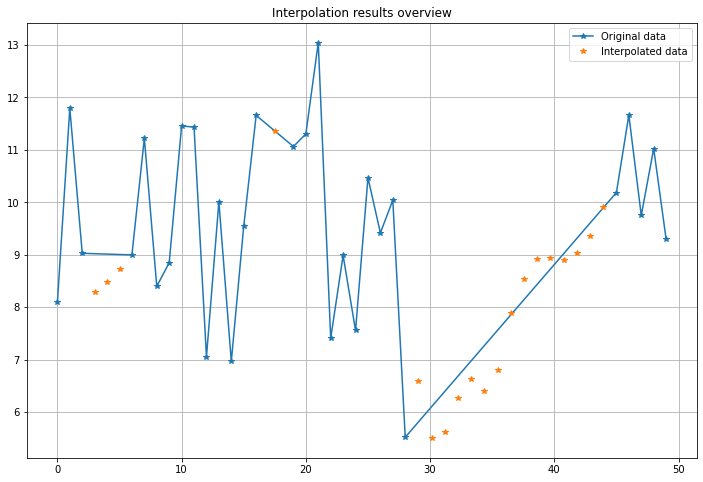

Ended execution


,X,Y,interpolated
0,0.0000,8.089846,0
1,1.0000,11.793489,0
2,2.0000,9.026726,0
3,3.0000,8.291588,1
4,4.0000,8.486541,1
5,5.0000,8.736440,1
6,6.0000,8.996177,0
7,7.0000,11.221730,0
8,8.0000,8.398122,0
9,9.0000,8.845667,0


In [11]:
# Interpolation, plot is optional (default False)
patched_df = interpolate_gaps( df , plot = True )
patched_df

## Brownian bridge algo: the theory

Allows to interpolate large gaps **preserving volatility** of the series (as an input!). Read about it [here "Brownian bridge"](https://introcs.cs.princeton.edu/python/23recursion/).

##### Weiner method to obtain the relevant std()

In a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process#Basic_properties) volatility (variance) is $$var = \Delta_t$$ so $$std = \sqrt{var} = \sqrt{\Delta_t}$$This sets how the **local volatility** should be analyzed.

So, if we have $std_{year}$ (or $std_{whole series}$), we can get the daily by: $$std_{year} = std_{day} \cdot  \sqrt{365} \Rightarrow std_{day} = \frac{std_{year}}{\sqrt{365}}$$

So we can get the "**basic building block**" of the volatility by getting $std_{minute}$ in our case.

Having $std_{minute}$, we then do a "bottom-up" process building the gap:

$$ std_{gap} = std_{minute} \cdot \sqrt{number\_of\_mins\_in\_gap}$$


_(Advice from Miguel, my colleague at ING)_

### Fixed timesteps

> You can use `fixed_freq` argument to make the **interpolated X points rounded to a certain timestep**. 'fixed_freq' timesteps defaults to 'min'. Valid options from Pandas, see link: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases

----

**Implementation of the rounding (you probably don't need to read this)** 

This constraint takes us **out of the brownian bridge**, because for it we only interpolate the **midpoints** through: 

\begin{cases}
x_m = \frac{x_0 + x_1}{2} \\
y_m = \frac{y_0 + y_1}{2} + std
\end{cases}

But, if we round up to mins, this midpoint $x_m$ could be different than a minute-exact timestamp (imagine the first interpolated point on a gap of 3m: it would be 1.5m). So **we round $x_m$**, and search for its **associated Y displacement** $\Delta y$:

\begin{cases} 
x'_m = x_m + \Delta x_{toroundtomin} \\ 
y'_m = y_m + \Delta y
\end{cases}

To get the associated $\Delta y$ we must use the **slope (derivative)** at that straight line between points $(x_0, y_0), (x_1, y_1)$.

So:

1- **Round up $x_m$ to the nearest minute** (lowest, `floor()`-like), so **we obtain**: $x'_m$, $\Delta x_{toroundtomin}$

2- The deltas on X and Y are related by the derivative, which we are implicitly assuming linear on the brownian bridge, so it's quite straightforward to calculate $\Delta y$:

$$ \Delta y := \frac{dy}{dx} \Delta x \Rightarrow  \Delta y \approx \frac{y_1 - y_0}{x_1 - x_0} \Delta x_{toroundtomin} $$

So we would have everything for the Y correction.